<a href="https://colab.research.google.com/github/VLCHS/MSU.AI/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting Started

In [1]:
!pip install --q wandb
!pip install --q wandb[media]
!pip install --q torch #==2.5.1
!pip install --q lightning #==2.4.0
!pip install --q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# necessary code, if wandb doesn't want to login for no reason
import os
os.environ['WANDB_INIT_TIMEOUT'] = '300'
os.environ['WANDB_HTTP_TIMEOUT'] = '300'
os.environ["WANDB__SERVICE_WAIT"] = "300"
os.environ['WANDB_DEBUG'] = 'true'
os.environ['WANDB_CORE_DEBUG'] = 'true'

In [3]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, KFold

import xgboost
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
)

from scipy import spatial
from random import randint
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)


def print_metrics(y_true, y_predicted):
    print(f"Mean squared error (MSE): {mean_squared_error(y_true, y_predicted):.3f}")
    print(f"Root mean squared error (RMSE): {root_mean_squared_error(y_true, y_predicted):.3f}")
    print(f"Mean absolute error (MAE): {mean_absolute_error(y_true, y_predicted):.3f}")
    print(f"R2: {r2_score(y_true, y_predicted):.3f}")


set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [4]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using gpu device


#Loading Data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [6]:
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
81073,2.04,1.7875,0.95,0.9,5.105088,0.000,0.000000,0.382683,-0.923880
81074,2.04,1.7875,0.95,0.9,5.366887,0.000,0.000000,0.608761,-0.793353
81075,2.04,1.7875,0.95,0.9,5.628687,0.000,0.000000,0.793353,-0.608761
81076,2.04,1.7875,0.95,0.9,5.890486,0.000,0.000000,0.923880,-0.382683


Text(0, 0.5, 'Q^2, GeV^2')

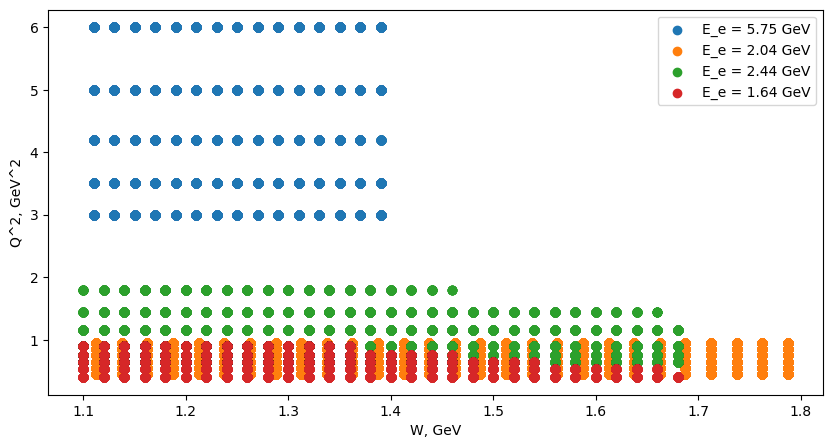

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

In [8]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_plus_n.txt to clasdb_pi_plus_n.txt


In [14]:
# e p-> e n pi+
df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset
df = df[~((df.Ebeam == 5.754) & (~df.Q2.isin([1.715, 2.050, 2.445, 2.915, 3.480, 4.155])))] # peculiarity of this dataset
df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
df_n = df_n.drop('id', axis=1)
df_n = df_n.reset_index(drop=True)
df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df_n = df_n.reset_index(drop=True)
df_n

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.515,1.11,0.3,0.991445,0.261799,15.3700,5.264366,0.965926,0.258819
1,1.515,1.11,0.3,0.991445,0.785398,4.5110,1.743136,0.707107,0.707107
2,1.515,1.11,0.3,0.991445,1.308997,4.4780,1.611260,0.258819,0.965926
3,1.515,1.11,0.3,0.991445,1.832596,5.1360,1.523529,-0.258819,0.965926
4,1.515,1.11,0.3,0.991445,2.356194,5.0780,1.219442,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
93430,5.499,2.01,4.0,0.975000,3.730641,0.1012,0.043165,-0.831470,-0.555570
93431,5.499,2.01,4.0,0.975000,3.992441,0.1199,0.076638,-0.659346,-0.751840
93432,5.499,2.01,4.0,0.975000,4.646939,0.1578,0.095391,-0.065403,-0.997859
93433,5.499,2.01,4.0,0.975000,4.777839,0.2346,0.158557,0.065403,-0.997859


Text(0, 0.5, 'Q^2, GeV^2')

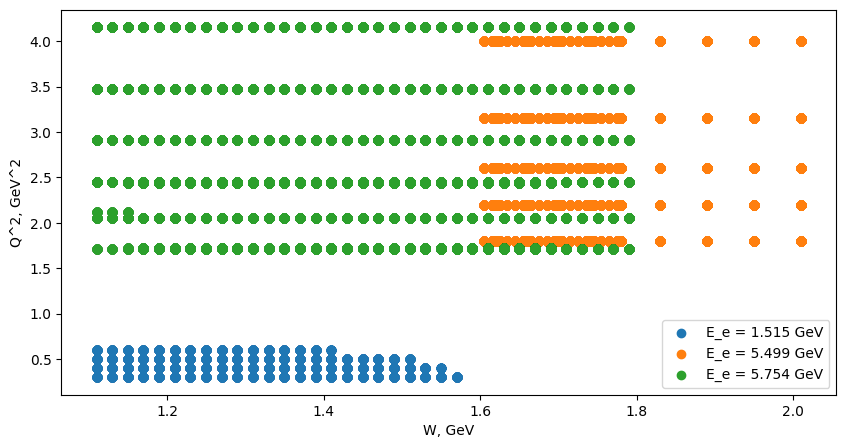

In [15]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df_n[df_n.Ebeam==1.515].W, df_n[df_n.Ebeam==1.515].Q2, label='E_e = 1.515 GeV')
plt.scatter(df_n[df_n.Ebeam==5.499].W, df_n[df_n.Ebeam==5.499].Q2, label='E_e = 5.499 GeV')
plt.scatter(df_n[df_n.Ebeam==5.754].W, df_n[df_n.Ebeam==5.754].Q2, label='E_e = 5.754 GeV')

plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#Classical Algorithms

In [42]:
feature_columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']
x = df[feature_columns].values
y = df['dsigma_dOmega'].values

# Splitting
set_random_seed(42)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


##Random Forest

In [43]:
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train,y_train)
y_pred_rf_reg = rf_reg.predict(x_test)

# Metrics
print_metrics(y_test, y_pred_rf_reg)

Mean squared error (MSE): 1.514
Root mean squared error (RMSE): 1.231
Mean absolute error (MAE): 0.566
R2: 0.900


In [44]:
def objective(trial):
    params = {
        "verbose": 0,
        "random_state": 42,

        "n_estimators": trial.suggest_int("n_estimators", 30, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 30),                   #20-25
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),    #2
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),     #2
        "max_features": trial.suggest_float("max_features", 0.6, 1.0, step=0.2),  #0.6
        "max_samples": trial.suggest_float("max_samples", 0.5, 1.0, step=0.1),   #0.9
    }
    model = RandomForestRegressor(**params)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    neg_mae = cross_val_score(
        model, x_train, y_train, cv=kf, scoring="neg_mean_absolute_error"
    ).mean()
    error = -neg_mae

    return error


# Create "exploration"
study_rf = optuna.create_study(direction="minimize", study_name="Optimizer", sampler=TPESampler(42))

study_rf.optimize(objective, n_trials=50)

[I 2025-06-01 19:28:29,616] A new study created in memory with name: Optimizer
[I 2025-06-01 19:28:34,665] Trial 0 finished with value: 1.8562203580705365 and parameters: {'n_estimators': 118, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_samples': 0.8}. Best is trial 0 with value: 1.8562203580705365.
[I 2025-06-01 19:28:39,364] Trial 1 finished with value: 0.6634332791014345 and parameters: {'n_estimators': 40, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.6, 'max_samples': 0.9}. Best is trial 1 with value: 0.6634332791014345.
[I 2025-06-01 19:28:45,349] Trial 2 finished with value: 0.6488598587139673 and parameters: {'n_estimators': 60, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.6, 'max_samples': 0.5}. Best is trial 2 with value: 0.6488598587139673.
[I 2025-06-01 19:29:12,144] Trial 3 finished with value: 0.6934517146155293 and parameters: {'n_estimators': 167, 'max_d

In [45]:
# show best params
study_rf.best_params

{'n_estimators': 99,
 'max_depth': 23,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 0.8,
 'max_samples': 0.9}

In [46]:
rf_optuna = RandomForestRegressor(**study_rf.best_params,
                                  random_state = 42,
                                  verbose=0,
)

rf_optuna.fit(x_train,y_train)
y_pred_rf_optuna = rf_optuna.predict(x_test)
print_metrics(y_test, y_pred_rf_optuna)

Mean squared error (MSE): 1.274
Root mean squared error (RMSE): 1.129
Mean absolute error (MAE): 0.541
R2: 0.916


##XGBoost

In [47]:
# Instantiation
xgb_reg_sk = XGBRegressor()

# Fitting the model
xgb_reg_sk.fit(x_train, y_train)

# Predict the model
y_pred_xgb_reg_sk = xgb_reg_sk.predict(x_test)

# Metrics
print_metrics(y_test, y_pred_xgb_reg_sk)

Mean squared error (MSE): 1.199
Root mean squared error (RMSE): 1.095
Mean absolute error (MAE): 0.564
R2: 0.921


In [48]:
def objective(trial):
    params = {
        "verbosity": 0,
        "random_state": 42,

        "n_estimators": trial.suggest_int("n_estimators", 20, 4000, step=10),
        "max_depth": trial.suggest_int("max_depth", 2, 20, step=1),   #7
        "max_leaves": trial.suggest_int("max_leaves", 20, 100, step=1),   #60
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 30, step=1),  #8
        "gamma": trial.suggest_float("gamma", 0, 10),  #0
        "eta": trial.suggest_float("eta", 1e-5, 0.5),     #0.3
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),      #0.9
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.2),    #1.0
    }
    model = XGBRegressor(**params)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    neg_mae = cross_val_score(
        model, x_train, y_train, cv=kf, scoring="neg_mean_absolute_error"
    ).mean()
    error = -neg_mae

    return error


# Create "exploration"
study_xgb = optuna.create_study(direction="minimize", study_name="Optimizer", sampler=TPESampler(42))

study_xgb.optimize(objective, n_trials=50)

[I 2025-06-01 19:42:55,780] A new study created in memory with name: Optimizer
[I 2025-06-01 19:43:04,651] Trial 0 finished with value: 0.6495638267618798 and parameters: {'n_estimators': 2650, 'max_depth': 20, 'max_leaves': 30, 'min_child_weight': 5, 'gamma': 7.814283484452638, 'eta': 0.11796160199815044, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.6495638267618798.
[I 2025-06-01 19:43:06,196] Trial 1 finished with value: 0.620378636013803 and parameters: {'n_estimators': 330, 'max_depth': 7, 'max_leaves': 96, 'min_child_weight': 6, 'gamma': 3.9575451519947826, 'eta': 0.35730922747804145, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.620378636013803.
[I 2025-06-01 19:43:07,356] Trial 2 finished with value: 0.7295500786758075 and parameters: {'n_estimators': 310, 'max_depth': 8, 'max_leaves': 39, 'min_child_weight': 3, 'gamma': 6.768708445044184, 'eta': 0.1452983251195469, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is tria

In [49]:
# show best params
study_xgb.best_params

{'n_estimators': 3600,
 'max_depth': 19,
 'max_leaves': 91,
 'min_child_weight': 25,
 'gamma': 2.842317812373016,
 'eta': 0.04134271278282372,
 'subsample': 0.7,
 'colsample_bytree': 0.8}

In [51]:
xgb_optuna = XGBRegressor(**study_xgb.best_params,
                          random_state = 42,
                          )

# Fitting the model
xgb_optuna.fit(x_train, y_train)

# Predict the model
y_pred_xgb_optuna = xgb_optuna.predict(x_test)

# Metrics
print_metrics(y_test, y_pred_xgb_optuna)

Mean squared error (MSE): 1.175
Root mean squared error (RMSE): 1.084
Mean absolute error (MAE): 0.546
R2: 0.922


##Compare Random Forest & XGBoost

In [52]:
def bootstrap_metric(y_true, y_pred, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for i in range(samples_cnt):
        poses = np.random.choice(y_true.shape[0], size=y_true.shape[0], replace=True)

        y_true_boot = y_true[poses]
        y_pred_boot = y_pred[poses]
        m_val = metric_fn(y_true_boot, y_pred_boot)
        b_metric[i] = m_val

    return b_metric

In [53]:
def train_and_test_regressor(models, metric, x_train, y_train, x_test, y_test, verb=True):
    boot_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        boot_scores[name] = bootstrap_metric(  # calculate bootstrap score
            y_test,
            y_pred,
            metric_fn=metric,
        )
        if verb:
            print(f"Fitted {name} with bootstrap score {boot_scores[name].mean():.3f}")

    results = pd.DataFrame(boot_scores)

    return results

In [54]:
models = {}

models["Random_Forest"] = RandomForestRegressor(**study_rf.best_params,
                                                random_state = 42,
                                                verbose=0,
)

models["XGBoost"] = XGBRegressor(**study_xgb.best_params,
                                 random_state = 42,
)

metric_rmse = root_mean_squared_error
results_boost_rmse = train_and_test_regressor(models, metric_rmse, x_train, y_train, x_test, y_test)

metric_mae = mean_absolute_error
results_boost_mae = train_and_test_regressor(models, metric_mae, x_train, y_train, x_test, y_test)

Fitted Random_Forest with bootstrap score 1.128
Fitted XGBoost with bootstrap score 1.084
Fitted Random_Forest with bootstrap score 0.541
Fitted XGBoost with bootstrap score 0.546


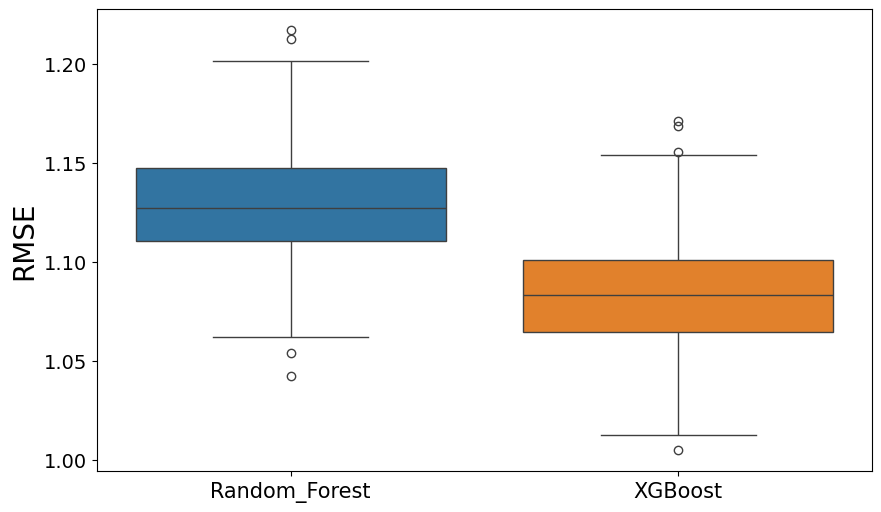

In [55]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=results_boost_rmse)
plt.xlabel("", size=20)
plt.ylabel("RMSE", size=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.show()

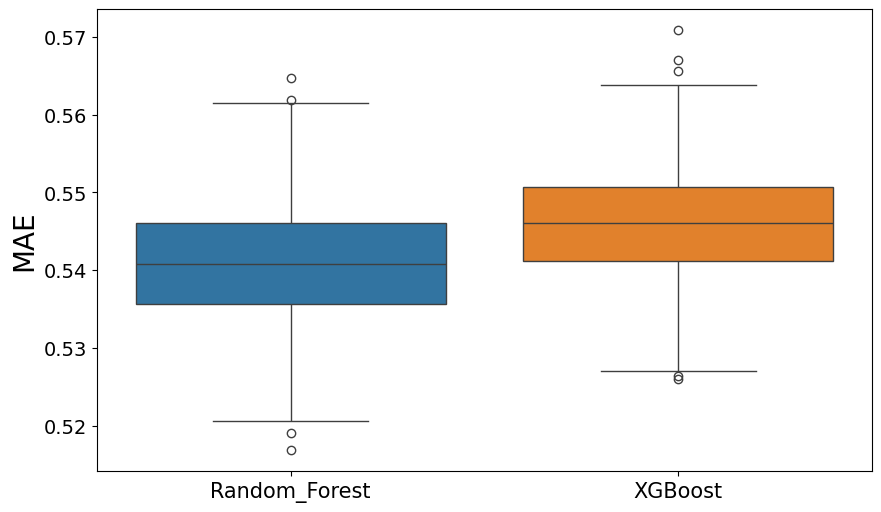

In [56]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=results_boost_mae)
plt.xlabel("", size=20)
plt.ylabel("MAE", size=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.show()

##Cross Sections Plots

In [59]:
# generate grid
# Ebeam = [1.64 2.44 5.75 2.04]
def generate_grid_df(Ebeam):
    df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
    df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
    df['phi'] = df.phi.apply(lambda x: math.radians(x))
    df['Ebeam'] = df['Ebeam'].round(decimals=2)
    df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
    df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
    df = df[df['error'] <= df["error"].quantile(0.98)]
    df = df.drop(df[df['dsigma_dOmega'] == 0].index)

    df = df.drop('id', axis=1)
    df = df.reset_index(drop=True)
    df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
    df = df.reset_index(drop=True)

    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
             for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                    for phi in np.arange(0, 2*np.pi, step_phi):
                        data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)

    dsigma_dOmega_predicted = rf_optuna.predict(df_grid.values)  #switch rf_optuna to xgb_optuna
    df_grid['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted

    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapezoid(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapezoid(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapezoid(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    df = df.drop_duplicates(['Ebeam', 'W', 'Q2', 'cos_theta', 'phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Экспериментальные данные. E\u2091: {E_beam}, W: {W}, Q\u00B2: {Q2}, cos \u03B8: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Фитированные данные'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Предсказанные данные'
             )


    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("\u03C6, рад", fontsize="20")
    plt.ylabel("d\u03C3_d\u03A9, мкб/ср", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    #plt.savefig(f'/content/NN/cross_sections/E_beam={Ebeam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-59-852da9097ee3>:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03433252573750339' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-59-852da9097ee3>:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.004356529357993232' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-59-852da9097ee3>:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.016034356676757615' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_mi

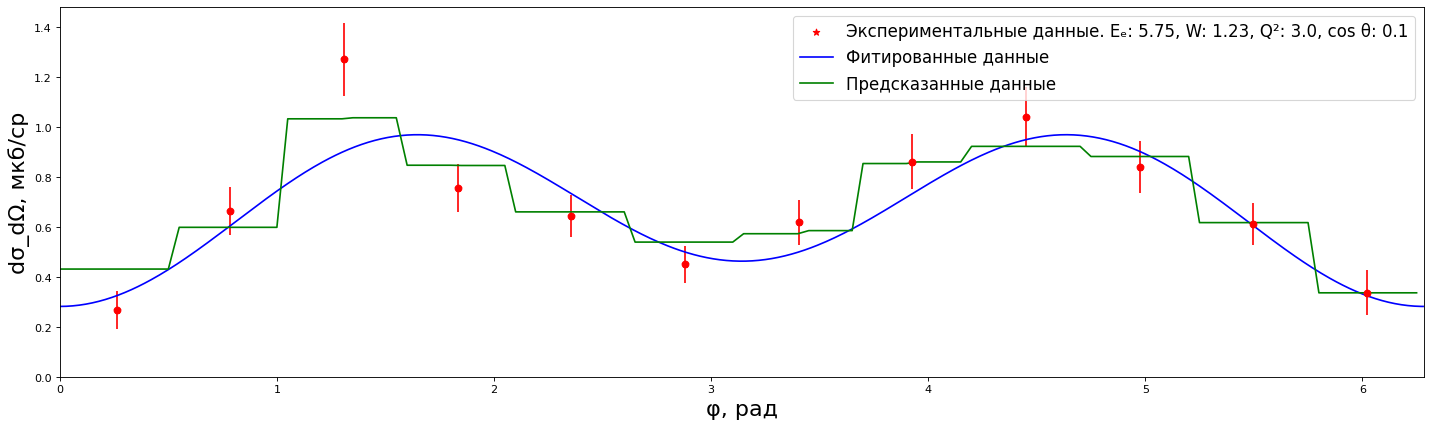

In [60]:
for E_beam in [5.75]:    #[1.64, 2.04, 2.44, 5.75]
    df_grid = generate_grid_df(E_beam)
    for Q2 in [3.0]:
        for W in [1.23]:
            for cos_theta in [0.1]:
                try:
                    plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid)
                except:
                    print(E_beam, W, Q2, cos_theta)

#Feedforward Neural Network

In [8]:
# Initialize wandb
wandb.init(entity='nucl_clas', project="FCNN for ep->ep_pi0, unified topology", name="Awesome_project")

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chistiakova-vv19 (nucl_clas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
#params for training
project_name = "FCNN for ep->ep_pi0, unified topology"
logger_path = '/wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'scale_data': True,
    'feature_scaler': StandardScaler(),
    'label_scaler': MinMaxScaler(),
    'augment': True,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': torch.nn.L1Loss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 150,
    'es_min_delta': 1e-05,
    'es_patience': 150,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

In [10]:
#VAE architecture and train_function for possible augmentation
class BasicVAE(nn.Module):
   def __init__(self, input_dim, latent_dim):
       super(BasicVAE, self).__init__()

       # Encoder
       self.encoder = nn.Sequential(
           nn.Linear(input_dim, 16),
           nn.ReLU(),
           nn.Linear(16, 64),
           nn.ReLU(),
           nn.Linear(64, 128),
           nn.ReLU(),
           nn.Linear(128, 256),
           nn.ReLU(),
           nn.Linear(256, 512),
           nn.ReLU()
       )
       self.fc_mu = nn.Linear(512, latent_dim)
       self.fc_logvar = nn.Linear(512, latent_dim)

       # Decoder
       self.decoder = nn.Sequential(
           nn.Linear(latent_dim, 512),
           nn.ReLU(),
           nn.Linear(512, 256),
           nn.ReLU(),
           nn.Linear(256, 128),
           nn.ReLU(),
           nn.Linear(128, 64),
           nn.ReLU(),
           nn.Linear(64, 16),
           nn.ReLU(),
           nn.Linear(16, input_dim)
       )

   def encode(self, x):
       h = self.encoder(x)
       mu = self.fc_mu(h)
       logvar = self.fc_logvar(h)
       return mu, logvar

   def reparameterize(self, mu, logvar):
       std = torch.exp(0.5 * logvar)
       eps = torch.randn_like(std)
       return mu + eps * std

   def decode(self, z):
       return self.decoder(z)

   def forward(self, x):
       mu, logvar = self.encode(x)
       z = self.reparameterize(mu, logvar)
       return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar, kld_weight=0.005, recon_weight=1.0):
   recon_loss = nn.MSELoss()(recon_x, x)

   # KL Divergence Loss
   kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
   return recon_weight * recon_loss + kld_weight * kld_loss

def train_vae(model, data_loader, epochs, learning_rate):
   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
   model.train()
   losses = []
   reconstruction_mse = []

   for epoch in range(epochs):
       total_loss = 0
       total_mse = 0
       for batch in data_loader:
           batch_data = batch[0]
           optimizer.zero_grad()
           reconstructed, mu, logvar = model(batch_data)
           loss = vae_loss(reconstructed, batch_data, mu, logvar)
           loss.backward()
           optimizer.step()
           total_loss += loss.item()

           # Compute batch-wise MSE for comparison
           mse = nn.MSELoss()(reconstructed, batch_data).item()
           total_mse += mse

       losses.append(total_loss / len(data_loader))
       reconstruction_mse.append(total_mse / len(data_loader))
       print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, MSE: {total_mse:.4f}")
   return losses, reconstruction_mse

In [11]:
wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name
logger_full_path = os.path.join(logger_path, project_name, exp_name)
os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0
        # reaction_type=1, it's used for Combined_df
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)                              #PREPROCESSING
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})                     #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] <= df_p['error']].index)         #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+,
        # # reaction_type=0, it's used for Combined_df
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)

        self.df = df

        feature_data = df.loc[:, ~df.columns.isin(["phi", "error", "dsigma_dOmega"])]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            num_samples = 30000
            batch_size = 128
            latent_dim = 64

            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            train_df_columns = list(train_df.columns.values)

            # Train-test split
            X_train, X_test = train_test_split(train_df, test_size=0.2, random_state=42)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Create DataLoaders
            train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)

            basic_vae = BasicVAE(input_dim=X_train.shape[1], latent_dim=latent_dim)

            basic_losses, basic_mse = train_vae(
               basic_vae, train_loader, epochs=50, learning_rate=0.0001,
            )

            # Visualize results
            plt.figure(figsize=(12, 6))
            plt.plot(basic_mse, label="Basic VAE")
            plt.ylabel("Reconstruction MSE")
            plt.title("Training Reconstruction MSE")
            plt.legend()
            plt.show()

            basic_vae.eval()
            z = torch.randn(num_samples, latent_dim)
            with torch.no_grad():
                generated_samples = basic_vae.decode(z).numpy()

            generated_samples = scaler.inverse_transform(generated_samples)
            new_df = pd.DataFrame(generated_samples, columns=train_df_columns)
            print(new_df)
            print(new_df.Ebeam.unique())

            plt.hist(X_train[:, 0], bins=30, alpha=0.5, label='real')
            plt.hist(generated_samples[:, 0], bins=30, alpha=0.5, label='synthetic')
            plt.legend()
            plt.show()

            augmented_train_df = pd.concat([train_df, new_df])
            augmented_train_df = augmented_train_df.sample(frac=1).reset_index(drop=True)

            train_label_data = augmented_train_df["dsigma_dOmega"]
            train_feature_data = augmented_train_df.loc[:, ~augmented_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        self.train_loss = self.loss_func(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        self.val_loss = self.loss_func(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')
        print_callback = PrintCallbacks()
        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


2025-06-01 20:11:23,293 : INFO : Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


INFO: GPU available: True (cuda), used: True


2025-06-01 20:11:23,332 : INFO : GPU available: True (cuda), used: True


INFO: TPU available: False, using: 0 TPU cores


2025-06-01 20:11:23,335 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2025-06-01 20:11:23,337 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2025-06-01 20:11:23,343 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
Epoch 1/50, Loss: 331.6688, MSE: 323.4660
Epoch 2/50, Loss: 222.6023, MSE: 206.6799
Epoch 3/50, Loss: 180.6325, MSE: 160.0278
Epoch 4/50, Loss: 169.0393, MSE: 147.9990
Epoch 5/50, Loss: 149.8851, MSE: 127.1349
Epoch 6/50, Loss: 115.1552, MSE: 90.3807
Epoch 7/50, Loss: 106.6460, MSE: 83.7664
Epoch 8/50, Loss: 98.5406, MSE: 76.4844
Epoch 9/50, Loss: 62.1870, MSE: 36.2969
Epoch 10/50, Loss: 52.2944, MSE: 27.2395
Epoch 11/50, Loss: 49.4774, MSE: 25.2136
Epoch 12/50, Loss: 46.0937, MSE: 23.0001
Epoch 13/50, Loss: 42.4206, MSE: 20.6769
Epoch 14/50, Loss: 40.4954, MSE: 19.6838
Epoch 15/50, Loss: 38.7094, MSE: 18.7918
Epoch 16/50, Loss: 36.7863, MSE: 17.7581
Epoch 17/50, Loss: 35.4018, MSE: 16.8299
Epoch 18/50, Loss: 34.6288, MSE: 16.0671
Epoch 19/50, Loss: 33.9770, MSE: 15.2807
Epoch 20/50, Loss: 33.3728, MSE: 14.5762
Ep

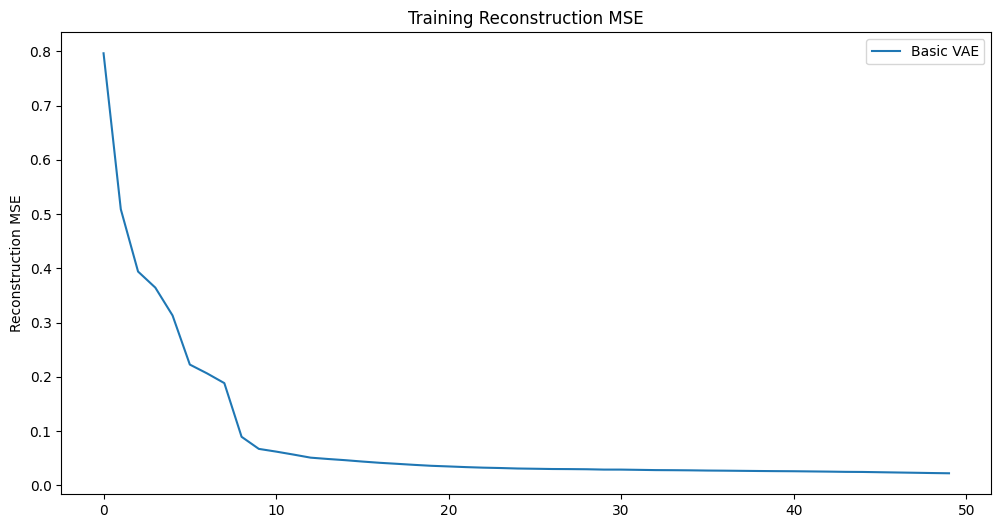

          Ebeam         W        Q2  cos_theta   cos_phi   sin_phi  \
0      2.008339  1.856281  0.580956   0.457212  0.744155 -0.749133   
1      1.988200  1.362764  0.694245  -0.760451 -0.125611  0.748054   
2      2.499675  1.414929  1.221832  -0.334481 -0.942464  0.575663   
3      1.919659  1.414777  0.616930   0.104386  0.696835 -0.577481   
4      5.610774  1.354786  2.694522  -0.659961 -0.438995  0.894620   
...         ...       ...       ...        ...       ...       ...   
29995  2.737407  1.676111  1.107090   0.564192 -1.165483  0.208937   
29996  2.186533  1.529506  0.803610   0.393072 -0.661518 -0.635454   
29997  1.919650  1.267939  0.661976  -0.047919  0.561913 -0.410481   
29998  1.995891  1.199893  0.673690   0.222735 -0.670615  0.735512   
29999  2.465299  1.211851  1.394123  -1.290226 -0.894101 -0.425683   

       dsigma_dOmega  
0           0.351256  
1           1.402111  
2           1.958983  
3           1.968689  
4           0.602211  
...              ... 

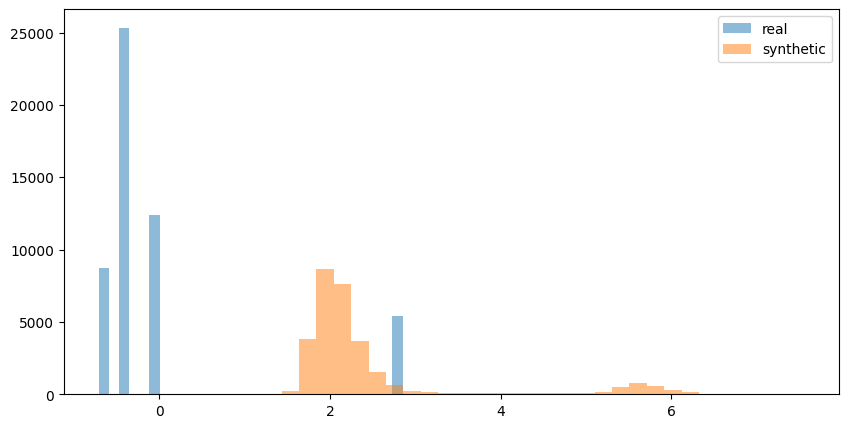

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2025-06-01 20:15:58,173 : INFO : LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | L1Loss              | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2025-06-01 20:15:58,456 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | L1Loss              | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2025-06-01 20:15:58,530 : INFO : Training is starting
2025-06-01 20:16:06,828 : INFO : epoch: 0; val_loss: 0.014280264265835285
202

INFO: Metric val_loss improved. New best score: 0.014


2025-06-01 20:16:06,866 : INFO : Metric val_loss improved. New best score: 0.014
2025-06-01 20:16:07,287 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.01428-epoch=00.ckpt
2025-06-01 20:16:12,918 : INFO : epoch: 1; val_loss: 0.008652319200336933
2025-06-01 20:16:12,923 : INFO : epoch: 1; train_loss: 0.011965813115239143


INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.009


2025-06-01 20:16:12,937 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.009
2025-06-01 20:16:13,037 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00865-epoch=01.ckpt
2025-06-01 20:16:18,252 : INFO : epoch: 2; val_loss: 0.007508714683353901
2025-06-01 20:16:18,257 : INFO : epoch: 2; train_loss: 0.009852156974375248


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.008


2025-06-01 20:16:18,285 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.008
2025-06-01 20:16:18,463 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00751-epoch=02.ckpt
2025-06-01 20:16:24,105 : INFO : epoch: 3; val_loss: 0.007027468644082546
2025-06-01 20:16:24,110 : INFO : epoch: 3; train_loss: 0.009056685492396355


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


2025-06-01 20:16:24,128 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007
2025-06-01 20:16:24,261 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00703-epoch=03.ckpt
2025-06-01 20:16:29,413 : INFO : epoch: 4; val_loss: 0.007348323706537485
2025-06-01 20:16:29,417 : INFO : epoch: 4; train_loss: 0.008678189478814602
2025-06-01 20:16:29,556 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00735-epoch=04.ckpt
2025-06-01 20:16:35,741 : INFO : epoch: 5; val_loss: 0.006995912175625563
2025-06-01 20:16:35,746 : INFO : epoch: 5; train_loss: 0.008512101136147976


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


2025-06-01 20:16:35,764 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007
2025-06-01 20:16:35,891 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00700-epoch=05.ckpt
2025-06-01 20:16:41,027 : INFO : epoch: 6; val_loss: 0.006443064659833908
2025-06-01 20:16:41,034 : INFO : epoch: 6; train_loss: 0.008221786469221115


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:16:41,053 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:16:41,155 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00644-epoch=06.ckpt
2025-06-01 20:16:48,273 : INFO : epoch: 7; val_loss: 0.006331111770123243
2025-06-01 20:16:48,278 : INFO : epoch: 7; train_loss: 0.008020092733204365


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:16:48,292 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:16:48,426 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00633-epoch=07.ckpt
2025-06-01 20:16:53,940 : INFO : epoch: 8; val_loss: 0.0064722285605967045
2025-06-01 20:16:53,945 : INFO : epoch: 8; train_loss: 0.008022980764508247
2025-06-01 20:16:54,116 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00647-epoch=08.ckpt
2025-06-01 20:17:00,619 : INFO : epoch: 9; val_loss: 0.006593609694391489
2025-06-01 20:17:00,623 : INFO : epoch: 9; train_loss: 0.007800295948982239
2025-06-01 20:17:05,985 : INFO : epoch: 10; val_loss: 0.006207813508808613
2025-06-01 20:17:05,989 : INFO : epoch: 10; train_loss: 0.0076752942986786366


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:17:06,010 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:17:06,152 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00621-epoch=10.ckpt
2025-06-01 20:17:12,718 : INFO : epoch: 11; val_loss: 0.006435899529606104
2025-06-01 20:17:12,722 : INFO : epoch: 11; train_loss: 0.007661658804863691
2025-06-01 20:17:12,873 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00644-epoch=11.ckpt
2025-06-01 20:17:19,928 : INFO : epoch: 12; val_loss: 0.006258244160562754
2025-06-01 20:17:19,932 : INFO : epoch: 12; train_loss: 0.007651920896023512
2025-06-01 20:17:20,140 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00626-epoch=12.ckpt
2025-06-01 20:17:26,174 : INFO : epoch: 13; val_loss: 0.006351487245410681


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:17:42,763 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:17:42,890 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00599-epoch=15.ckpt
2025-06-01 20:17:48,793 : INFO : epoch: 16; val_loss: 0.005981673486530781
2025-06-01 20:17:48,798 : INFO : epoch: 16; train_loss: 0.007001582533121109
2025-06-01 20:17:48,944 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00598-epoch=16.ckpt
2025-06-01 20:17:56,190 : INFO : epoch: 17; val_loss: 0.005992483347654343
2025-06-01 20:17:56,196 : INFO : epoch: 17; train_loss: 0.006966072134673595
2025-06-01 20:17:56,396 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00599-epoch=17.ckpt
2025-06-01 20:18:02,129 : INFO : epoch: 18; val_loss: 0.00586291216313839
2

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:18:02,149 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:18:02,279 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00586-epoch=18.ckpt
2025-06-01 20:18:11,953 : INFO : epoch: 19; val_loss: 0.0059026614762842655
2025-06-01 20:18:11,957 : INFO : epoch: 19; train_loss: 0.0069300089962780476
2025-06-01 20:18:12,095 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00590-epoch=19.ckpt
2025-06-01 20:18:17,335 : INFO : epoch: 20; val_loss: 0.0060803089290857315
2025-06-01 20:18:17,340 : INFO : epoch: 20; train_loss: 0.006894106511026621
2025-06-01 20:18:23,777 : INFO : epoch: 21; val_loss: 0.005838437471538782
2025-06-01 20:18:23,781 : INFO : epoch: 21; train_loss: 0.006825221236795187


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:18:23,800 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:18:23,927 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00584-epoch=21.ckpt
2025-06-01 20:18:29,174 : INFO : epoch: 22; val_loss: 0.005919731687754393
2025-06-01 20:18:29,179 : INFO : epoch: 22; train_loss: 0.006794927641749382
2025-06-01 20:18:34,977 : INFO : epoch: 23; val_loss: 0.005684356205165386
2025-06-01 20:18:34,981 : INFO : epoch: 23; train_loss: 0.0067320954985916615


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:18:34,999 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:18:35,141 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00568-epoch=23.ckpt
2025-06-01 20:18:43,099 : INFO : epoch: 24; val_loss: 0.005766912363469601
2025-06-01 20:18:43,108 : INFO : epoch: 24; train_loss: 0.0067449696362018585
2025-06-01 20:18:43,266 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00577-epoch=24.ckpt
2025-06-01 20:18:55,787 : INFO : epoch: 25; val_loss: 0.005821974016726017
2025-06-01 20:18:55,795 : INFO : epoch: 25; train_loss: 0.006696198135614395
2025-06-01 20:18:56,026 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00582-epoch=25.ckpt
2025-06-01 20:19:03,056 : INFO : epoch: 26; val_loss: 0.005750839132815599

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:19:14,264 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:19:14,396 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00565-epoch=28.ckpt
2025-06-01 20:19:19,881 : INFO : epoch: 29; val_loss: 0.005834192968904972
2025-06-01 20:19:19,886 : INFO : epoch: 29; train_loss: 0.00660561490803957
2025-06-01 20:19:25,666 : INFO : epoch: 30; val_loss: 0.0058609237894415855
2025-06-01 20:19:25,672 : INFO : epoch: 30; train_loss: 0.006603552028536797
2025-06-01 20:19:30,797 : INFO : epoch: 31; val_loss: 0.005972182843834162
2025-06-01 20:19:30,801 : INFO : epoch: 31; train_loss: 0.006520729977637529
2025-06-01 20:19:36,849 : INFO : epoch: 32; val_loss: 0.005635860841721296
2025-06-01 20:19:36,853 : INFO : epoch: 32; train_loss: 0.006340745836496353


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:19:36,877 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:19:37,027 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00564-epoch=32.ckpt
2025-06-01 20:19:42,754 : INFO : epoch: 33; val_loss: 0.005746837239712477
2025-06-01 20:19:42,761 : INFO : epoch: 33; train_loss: 0.00632055476307869
2025-06-01 20:19:49,681 : INFO : epoch: 34; val_loss: 0.005607656668871641
2025-06-01 20:19:49,686 : INFO : epoch: 34; train_loss: 0.006316476501524448


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:19:49,703 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:19:49,855 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00561-epoch=34.ckpt
2025-06-01 20:19:56,343 : INFO : epoch: 35; val_loss: 0.005807361099869013
2025-06-01 20:19:56,348 : INFO : epoch: 35; train_loss: 0.006273305509239435
2025-06-01 20:20:02,805 : INFO : epoch: 36; val_loss: 0.005578707903623581
2025-06-01 20:20:02,811 : INFO : epoch: 36; train_loss: 0.006286109331995249


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:20:02,830 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:20:02,984 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00558-epoch=36.ckpt
2025-06-01 20:20:08,485 : INFO : epoch: 37; val_loss: 0.005609909072518349
2025-06-01 20:20:08,489 : INFO : epoch: 37; train_loss: 0.006275916006416082
2025-06-01 20:20:08,657 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00561-epoch=37.ckpt
2025-06-01 20:20:14,941 : INFO : epoch: 38; val_loss: 0.00563776446506381
2025-06-01 20:20:14,946 : INFO : epoch: 38; train_loss: 0.0062386654317379
2025-06-01 20:20:21,166 : INFO : epoch: 39; val_loss: 0.005553149152547121
2025-06-01 20:20:21,170 : INFO : epoch: 39; train_loss: 0.006247008219361305


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:20:21,189 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:20:21,321 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00555-epoch=39.ckpt
2025-06-01 20:20:27,323 : INFO : epoch: 40; val_loss: 0.00558820366859436
2025-06-01 20:20:27,327 : INFO : epoch: 40; train_loss: 0.0062376968562603
2025-06-01 20:20:27,479 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00559-epoch=40.ckpt
2025-06-01 20:20:33,397 : INFO : epoch: 41; val_loss: 0.005546602886170149
2025-06-01 20:20:33,402 : INFO : epoch: 41; train_loss: 0.006208506878465414
2025-06-01 20:20:33,551 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00555-epoch=41.ckpt
2025-06-01 20:20:39,751 : INFO : epoch: 42; val_loss: 0.005533885210752487
202

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:20:39,778 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:20:39,915 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00553-epoch=42.ckpt
2025-06-01 20:20:45,148 : INFO : epoch: 43; val_loss: 0.005589813459664583
2025-06-01 20:20:45,153 : INFO : epoch: 43; train_loss: 0.006188481114804745
2025-06-01 20:20:51,057 : INFO : epoch: 44; val_loss: 0.005822191014885902
2025-06-01 20:20:51,062 : INFO : epoch: 44; train_loss: 0.006179101765155792
2025-06-01 20:20:56,320 : INFO : epoch: 45; val_loss: 0.005538574885576963
2025-06-01 20:20:56,325 : INFO : epoch: 45; train_loss: 0.006151218898594379
2025-06-01 20:20:56,478 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00554-epoch=45.ckpt
2025-06-01 20:21:02,642 : INFO : epoch: 46; val_loss: 0.005516307428479195
2025-06-01 20:21:0

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:21:02,667 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:21:02,804 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00552-epoch=46.ckpt
2025-06-01 20:21:07,993 : INFO : epoch: 47; val_loss: 0.005684524774551392
2025-06-01 20:21:08,000 : INFO : epoch: 47; train_loss: 0.006114466115832329
2025-06-01 20:21:13,775 : INFO : epoch: 48; val_loss: 0.0055642626248300076
2025-06-01 20:21:13,784 : INFO : epoch: 48; train_loss: 0.006123376078903675
2025-06-01 20:21:19,150 : INFO : epoch: 49; val_loss: 0.005609434563666582
2025-06-01 20:21:19,154 : INFO : epoch: 49; train_loss: 0.006116337608546019
2025-06-01 20:21:25,082 : INFO : epoch: 50; val_loss: 0.0055162496864795685
2025-06-01 20:21:25,090 : INFO : epoch: 50; train_loss: 0.005977500230073929
2025-06-01 20:21:25,285 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


2025-06-01 20:21:31,089 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
2025-06-01 20:21:31,228 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00551-epoch=51.ckpt
2025-06-01 20:21:36,764 : INFO : epoch: 52; val_loss: 0.0054962425492703915
2025-06-01 20:21:36,772 : INFO : epoch: 52; train_loss: 0.005948267877101898
2025-06-01 20:21:36,979 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00550-epoch=52.ckpt
2025-06-01 20:21:42,779 : INFO : epoch: 53; val_loss: 0.005453945603221655
2025-06-01 20:21:42,784 : INFO : epoch: 53; train_loss: 0.005941228941082954


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


2025-06-01 20:21:42,803 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005
2025-06-01 20:21:42,910 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00545-epoch=53.ckpt
2025-06-01 20:21:48,440 : INFO : epoch: 54; val_loss: 0.005502202548086643
2025-06-01 20:21:48,444 : INFO : epoch: 54; train_loss: 0.005935554392635822
2025-06-01 20:21:48,592 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00550-epoch=54.ckpt
2025-06-01 20:21:54,478 : INFO : epoch: 55; val_loss: 0.0055350675247609615
2025-06-01 20:21:54,485 : INFO : epoch: 55; train_loss: 0.0059357271529734135
2025-06-01 20:21:59,744 : INFO : epoch: 56; val_loss: 0.0054766228422522545
2025-06-01 20:21:59,748 : INFO : epoch: 56; train_loss: 0.005928743164986372
2025-06-01 20:21:59,867 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unifie

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


2025-06-01 20:22:40,598 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005
2025-06-01 20:22:40,712 : DEBUG : open file: /wandb_local_logs/FCNN for ep->ep_pi0, unified topology/Awesome_project/checkpoints/exp_name=0val_loss=0.00541-epoch=63.ckpt
2025-06-01 20:22:46,550 : INFO : epoch: 64; val_loss: 0.005467565730214119
2025-06-01 20:22:46,555 : INFO : epoch: 64; train_loss: 0.005863815546035767
2025-06-01 20:22:52,454 : INFO : epoch: 65; val_loss: 0.005480055697262287
2025-06-01 20:22:52,459 : INFO : epoch: 65; train_loss: 0.00585016468539834
2025-06-01 20:22:58,008 : INFO : epoch: 66; val_loss: 0.005482518579810858
2025-06-01 20:22:58,014 : INFO : epoch: 66; train_loss: 0.00585863646119833
2025-06-01 20:23:04,029 : INFO : epoch: 67; val_loss: 0.005462516099214554
2025-06-01 20:23:04,034 : INFO : epoch: 67; train_loss: 0.005783644039183855
2025-06-01 20:23:09,310 : INFO : epoch: 68; val_loss: 0.005487982649356127
2025-06-01 20:23:09,316 : INFO : epoch

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.


2025-06-01 20:30:38,167 : INFO : `Trainer.fit` stopped: `max_epochs=150` reached.
2025-06-01 20:30:38,169 : INFO : Training is ending


In [12]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

In [13]:
wandb.finish()

2025-06-01 20:30:59,006 : DEBUG : Using selector: EpollSelector


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr_scheduler_monitoring,████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▅▆▆▇▇▇▇▇▇▇█████████████████████████████
train_rmse,█▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▄▃▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▃▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


##Cross Sections & Structure Functions Plots

In [19]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapezoid(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapezoid(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapezoid(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Экспериментальные данные. E\u2091: {E_beam}, W: {W}, Q\u00b2: {Q2}, cos \u03B8: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Фитированные данные'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Предсказанные данные'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("\u03C6, рад", fontsize="20")
    plt.ylabel("d\u03C3_d\u03A9, мкб/ср", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    #plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Экспериментальные данные. E\u2091: {E_beam}, Q\u00b2: {Q2}, cos \u03B8: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"Предсказанные данные")

    plt.xlabel("W, ГэВ", fontsize="20")
    plt.ylabel(f"{func}, мкб/ср", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    #plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [20]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 177/177 [00:04<00:00, 36.86it/s]
<ipython-input-19-daf691f4d632>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-19-daf691f4d632>:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.02146104909479618' has dtype incompatible with int64, ple

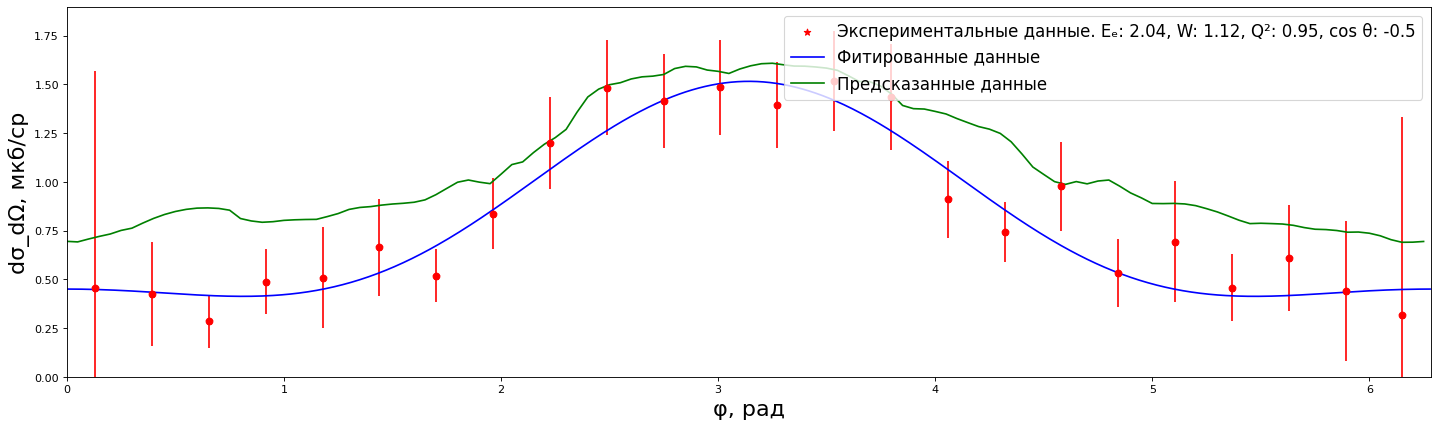

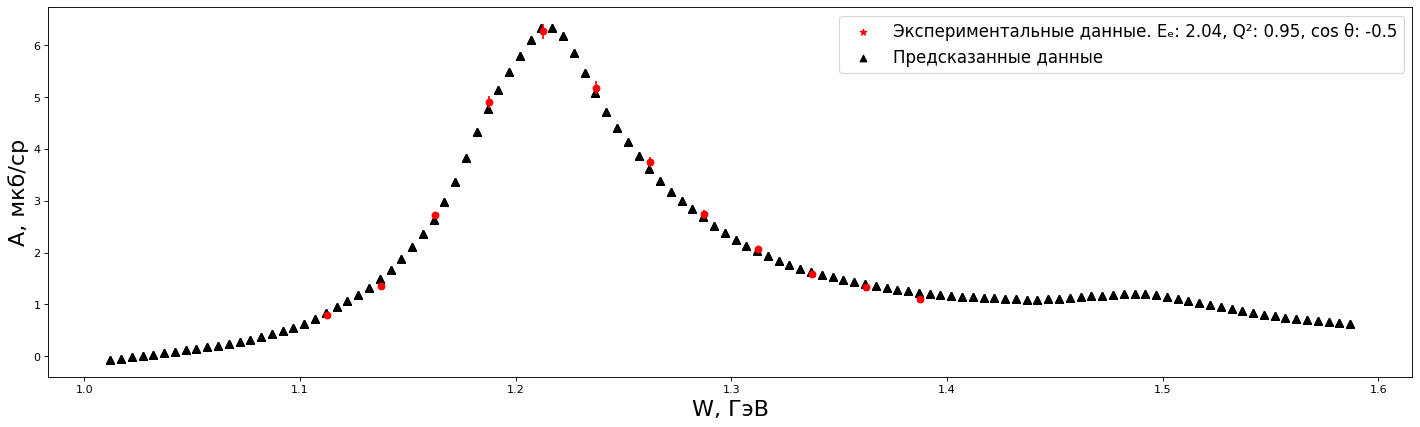

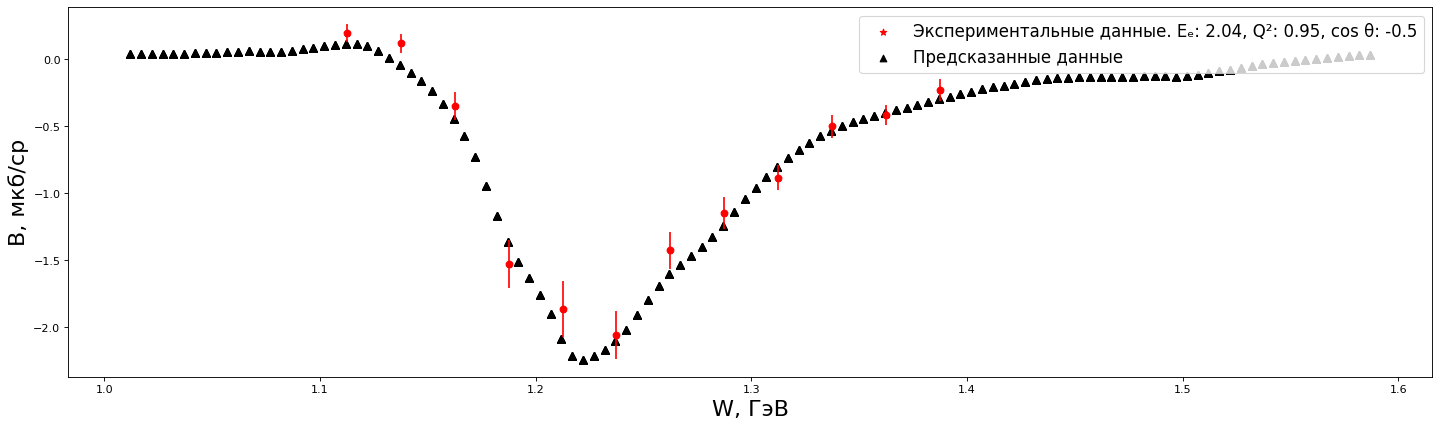

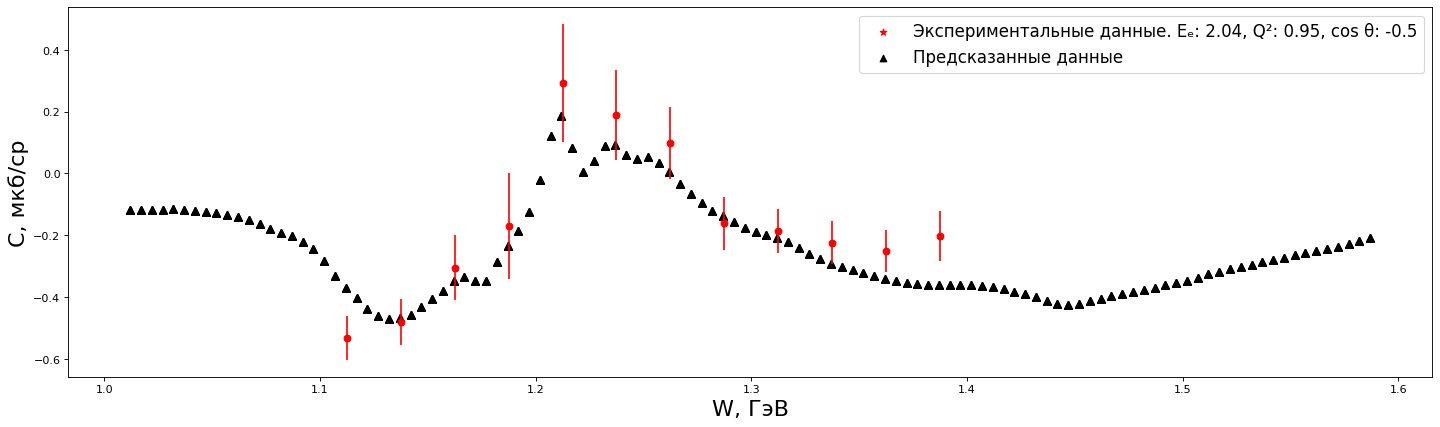

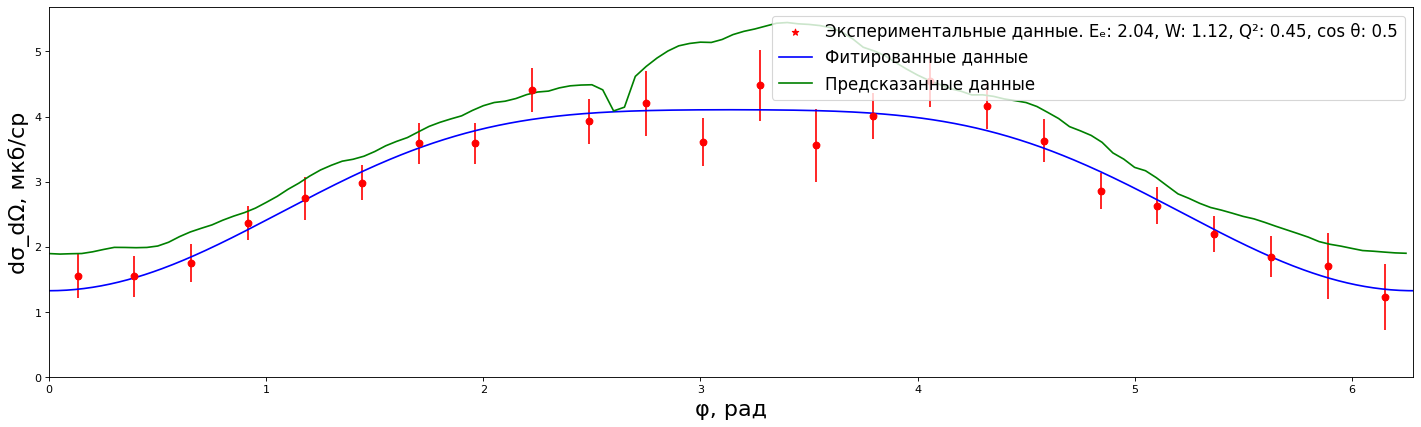

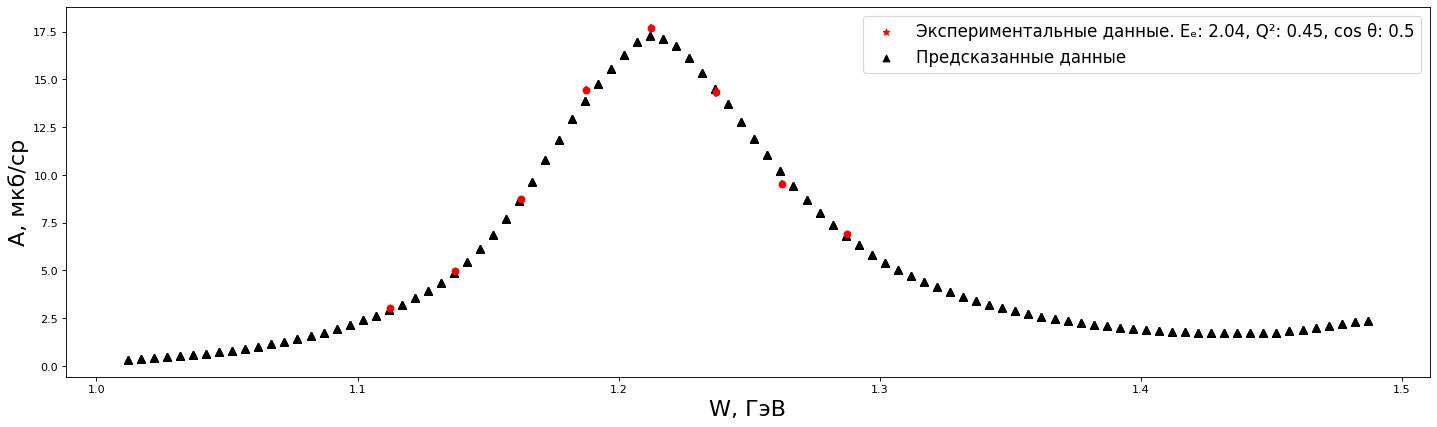

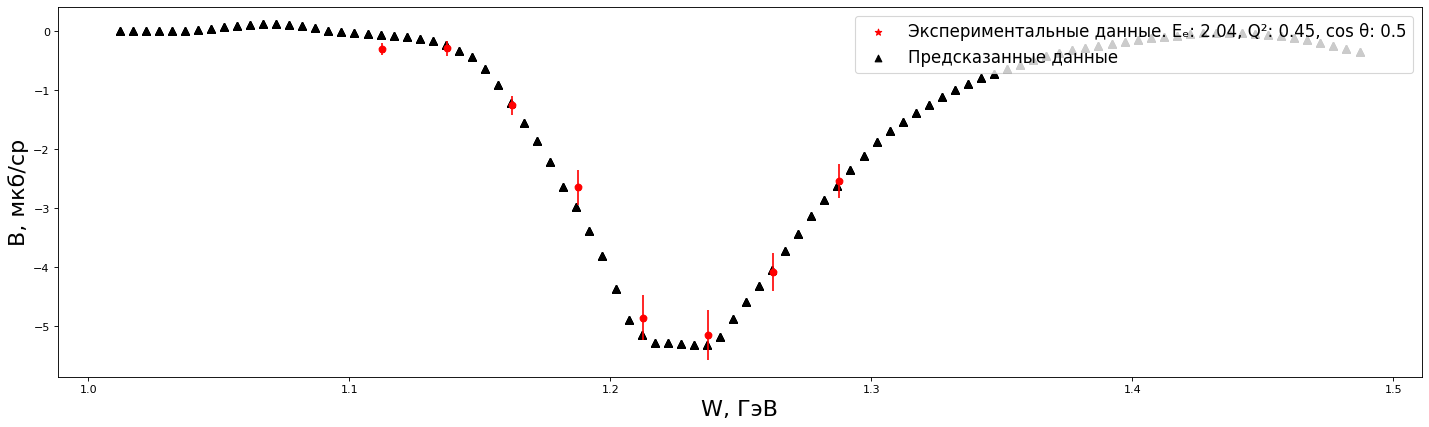

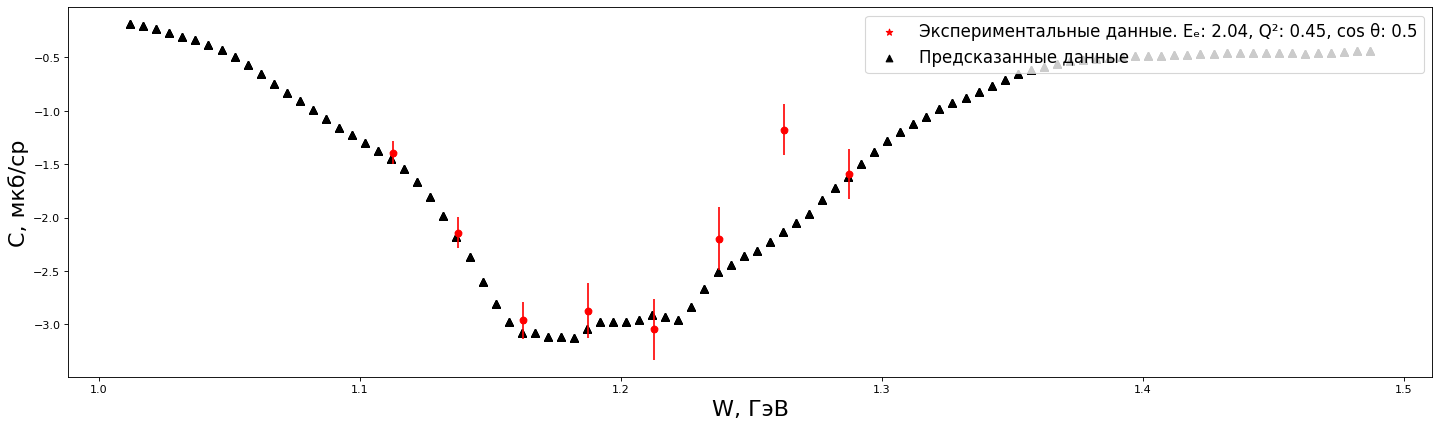

In [21]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [2.04]:   #[1.64, 2.44, 5.75, 2.04]
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)